In [1]:
%run ./data_utils.ipynb
%run ./model.ipynb

In [2]:
dataUtils = DataUtils(min_word_frequency = 2)
sentences_train, sentence_test, classes_train, classes_test = dataUtils.get_glove_sentence_class(0.01)

loading data ...
---done!---
creating vocabulary ...
---done!---
numericalizing sentences ...
---done!---!
sentences: 7109 sentences: 7109 Vocab: 8458
loading glove ...
---done!---


In [44]:
embed_size = 300
hidden_size = 150
vocab_size = len(dataUtils.vocabulary)
class_size = 10
num_layers = 2

learning_rate = 6e-4
num_epochs = 30
load_model = False
save_model = True
batch_size = 16
valid_batch_size = 100

In [45]:
train_data = Dataset(sentences_train, classes_train)
validation_data = Dataset(sentence_test, classes_test)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_data, batch_size=valid_batch_size, shuffle=True)

In [5]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
%run ./data_utils.ipynb
%run ./model.ipynb
model = RelationNet_glove(embed_size, hidden_size, vocab_size, class_size, num_layers).to(device)
criterion = nn.NLLLoss(ignore_index = dataUtils.rev_vocabulary["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

if load_model:
    model = torch.load("my_checkpoint_glove.pth.tar")

In [7]:
train_losses = []
train_accs = []
validation_losses = []
validation_accs = []

In [8]:
model.train()
dataloader_iterator = iter(validation_loader)
validation_sentences, validation_classes = next(dataloader_iterator)
validation_sentences, validation_classes = validation_sentences.to(device), validation_classes.to(device)

for epoch in range(num_epochs):
    batches_losses = []
    batches_accs = []
    print('-'*8+"epoch:"+str(epoch)+'-'*8)

    for idx, (sentence, c) in enumerate(train_loader):
        sentence, c = sentence.to(device), c.to(device)

        outputs = model(sentence)
        loss = criterion(outputs, c)
        
        batches_losses.append(loss.item())
        batches_accs.append(1-torch.count_nonzero(torch.argmax(outputs, dim = 1)-c)/batch_size)
        
        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()
        
        print(str(round(idx/440*100, 2))+'%', end="\r")
        
    train_losses.append(np.array(batches_losses).mean()) 
    train_accs.append(np.array(batches_accs).mean())
    
    validation_outputs = model(validation_sentences)
    validation_loss = criterion(validation_outputs, validation_classes)
    validation_losses.append(validation_loss.item())
    validation_accs.append(1-float(torch.count_nonzero(torch.argmax(validation_outputs, dim = 1)-validation_classes)/valid_batch_size))
    
    if save_model and validation_accs[-1] >= max(validation_accs):
        print('saving model ...')
        torch.save(model, "my_checkpoint_glove.pth.tar")
    
    print("epoch train loss:\t"+ str(round(train_losses[-1],3)) + "\tepoch validation loss:\t" + str(round(validation_losses[-1],3)))
    print("epoch train acc:\t" + str(round(train_accs[-1],3)) + "\tepoch validation acc:\t" + str(round(validation_accs[-1],3)))
    

--------epoch:0--------
saving model ...
epoch train loss:	1.694	epoch validation loss:	1.598
epoch train acc:	0.335	epoch validation acc:	0.375
--------epoch:1--------
saving model ...
epoch train loss:	1.244	epoch validation loss:	1.387
epoch train acc:	0.485	epoch validation acc:	0.475
--------epoch:2--------
saving model ...
epoch train loss:	1.086	epoch validation loss:	1.408
epoch train acc:	0.532	epoch validation acc:	0.5
--------epoch:3--------
saving model ...
epoch train loss:	0.976	epoch validation loss:	1.188
epoch train acc:	0.57	epoch validation acc:	0.55
--------epoch:4--------
epoch train loss:	0.875	epoch validation loss:	1.199
epoch train acc:	0.602	epoch validation acc:	0.5
--------epoch:5--------
epoch train loss:	0.793	epoch validation loss:	1.366
epoch train acc:	0.627	epoch validation acc:	0.45
--------epoch:6--------
saving model ...
epoch train loss:	0.727	epoch validation loss:	1.15
epoch train acc:	0.652	epoch validation acc:	0.55
--------epoch:7--------
epoc

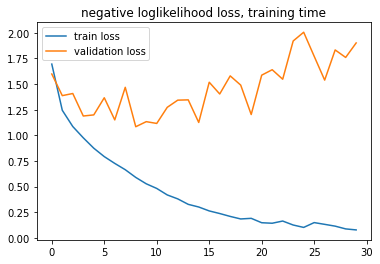

In [9]:
plt.plot(train_losses, label = "train loss")
plt.plot(validation_losses, label = "validation loss")
plt.title("negative loglikelihood loss, training time")
plt.legend()

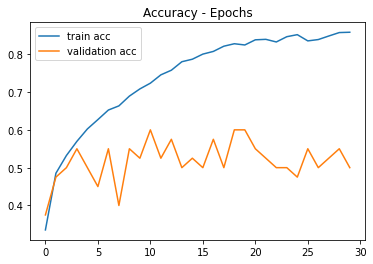

In [10]:
plt.plot(train_accs, label = "train acc")
plt.plot(validation_accs, label = "validation acc")
plt.title("Accuracy - Epochs")
plt.legend()

In [57]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

model = RelationNet_glove(embed_size, hidden_size, vocab_size, class_size, num_layers).to(device)
criterion = nn.NLLLoss(ignore_index = dataUtils.rev_vocabulary["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = torch.load("my_checkpoint_glove.pth.tar")

dataloader_iterator = iter(validation_loader)
validation_sentences, validation_classes = next(dataloader_iterator)
validation_sentences, validation_classes = validation_sentences.to(device), validation_classes.to(device)
validation_outputs = model(validation_sentences)

In [58]:
accuracy_score(validation_classes, torch.argmax(validation_outputs, dim = 1))

0.5833333333333334

In [59]:
confusion_matrix(validation_classes, torch.argmax(validation_outputs, dim = 1))

array([[0, 0, 0, 0, 0, 0, 0, 0, 3, 2],
       [0, 7, 1, 0, 1, 1, 0, 0, 1, 0],
       [0, 0, 7, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 7, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 5, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 3, 1, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 1, 1, 2, 1, 0, 0, 4, 4, 2],
       [0, 0, 0, 1, 0, 0, 1, 0, 1, 5]])

In [61]:
a = precision_recall_fscore_support(validation_classes, np.array(torch.argmax(validation_outputs, dim = 1)))

/Users/ali/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
a[2].mean()

0.552521645021645